# Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

A data generator and some examples are provided below.

# Data preparation

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt

In [2]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Let us split the images in two groups, according to their label.

In [3]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

truck


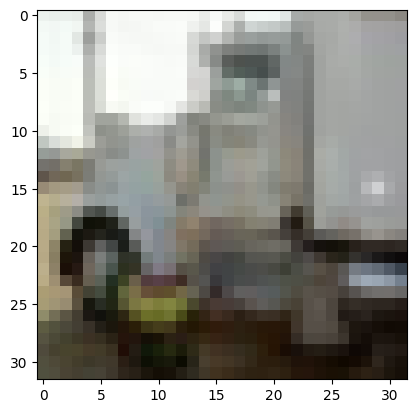

In [4]:
plt.imshow(cifar10_x_train_2[15])
print(classes[cifar10_y_train_2[15][0]])

Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.

In [5]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = (Y1_cat[num1],Y2_cat[num2])

    yield x_data, y_data


Let us instantiate a generator on Cifar10 with batchsize=1, and let's see its behaviour.

In [6]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

In [7]:
next(datagen)[1]

(array([[1., 0., 0., 0., 0.]]), array([[1., 0., 0., 0., 0.]]))

Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.

first: deer, second = truck


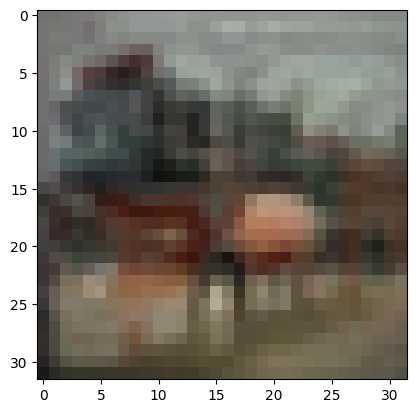

In [8]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# Model Definition

In [9]:
import keras
from keras import ops

In [63]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 1000  # For real training, use num_epochs=100. 10 is a test value
image_size = 32  # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
    512,
    256,
]  # Size of the dense layers of the final classifier


In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

15322


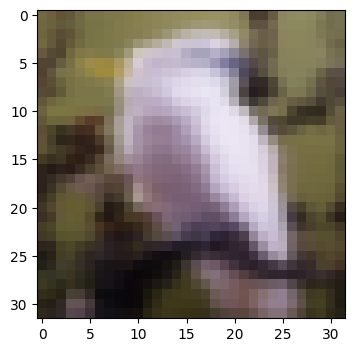

Image size: 32 X 32
Patch size: 4 X 4
Images in batch: 2
Patches per image: 64
Elements per patch: 48


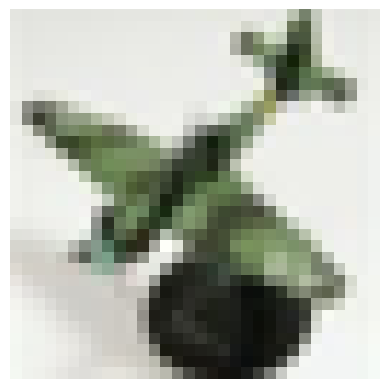

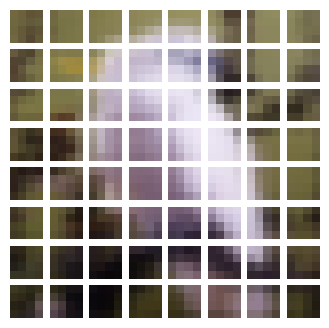

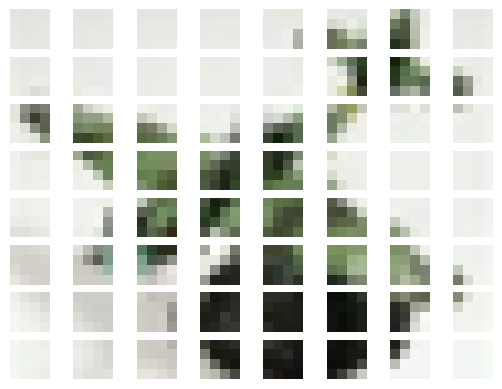

In [64]:
plt.figure(figsize=(4, 4))
rnd_idx = np.random.randint(0,cifar10_x_train_1.shape[0])
print(rnd_idx)
images = cifar10_x_train_1[rnd_idx:rnd_idx+2]
plt.imshow(images[0])
plt.show()
plt.imshow(images[1])
plt.axis("off")

'''
resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
'''

patches = Patches(patch_size)(images)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Images in batch: {patches.shape[0]}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for j in range(len(patches)):
  for i, patch in enumerate(patches[j]):
      ax = plt.subplot(n, n, i + 1)
      patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
      plt.imshow(ops.convert_to_numpy(patch_img))
      plt.axis("off")
  plt.show()

In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [50]:
def create_vit_classifier():
    inputs = keras.Input(shape=(image_size, image_size,3))

    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.15)(representation)

    # mlps
    features_im1 = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)
    features_im2 = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)

    # Classify outputs
    logits_im1 = layers.Dense(5)(features_im1)
    logits_im2 = layers.Dense(5)(features_im2)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=[logits_im1,logits_im2])
    return model

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - dense_121_accuracy: 0.1910 - dense_121_loss: 3.1412 - dense_122_accuracy: 0.2024 - dense_122_loss: 2.9760 - loss: 6.1172
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - dense_121_accuracy: 0.2006 - dense_121_loss: 1.6441 - dense_122_accuracy: 0.2004 - dense_122_loss: 1.6505 - loss: 3.2947
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - dense_121_accuracy: 0.1983 - dense_121_loss: 1.6237 - dense_122_accuracy: 0.2090 - dense_122_loss: 1.6143 - loss: 3.2380
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - dense_121_accuracy: 0.2052 - dense_121_loss: 1.6147 - dense_122_accuracy: 0.2289 - dense_122_loss: 1.6107 - loss: 3.2253
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - dense_121_accuracy: 0.2328 - dense_121_loss: 1.6007 - dense_122_accuracy: 0.2188 - dense_122_loss: 1.6150 - loss: 3.2157
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - dense_121_accuracy: 0.2688 - dense_121_loss: 1.5780 - dense_122_

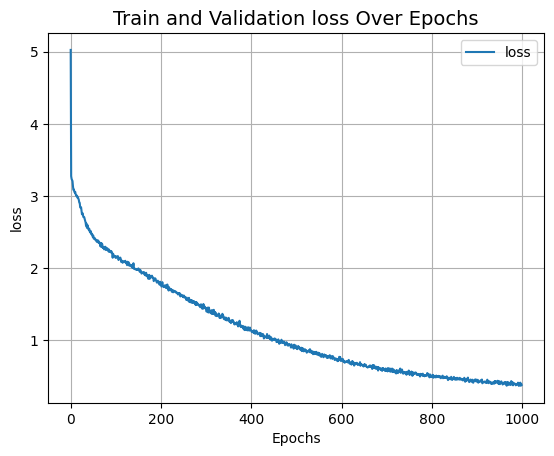

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

datagen1 = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,batch_size)

def loss_fn(y_true, y_pred):
  y_true1 = y_true[0]
  y_true2 = y_true[1]

  y_pred1 = y_pred[0]
  y_pred2 = y_pred[1]

  loss1 = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true1, y_pred1)
  loss2 = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_true2, y_pred2)

  return (loss1 + loss2)/2

def average_accuracy(y_true, y_pred):
    y_true1 = y_true[0]
    y_true2 = y_true[1]

    y_pred1 = y_pred[0]
    y_pred2 = y_pred[1]

    correct_guesses_1 = y_pred1 == np.argmax(y_true1,axis=1)
    correct_guesses_2 = y_pred2 == np.argmax(y_true2,axis=1)
    return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=[keras.losses.CategoricalCrossentropy(from_logits=True), keras.losses.CategoricalCrossentropy(from_logits=True)],
        metrics=['accuracy', 'accuracy'],
    )

    early_stopping = EarlyStopping(monitor="loss",
      mode = "max",
      patience=5,
      restore_best_weights=True)

    history = model.fit(datagen1,
        batch_size=batch_size,
        steps_per_epoch = 20,
        epochs=num_epochs,
        #callbacks=[early_stopping],
    )

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    #plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")

# Model Evaluation

Let us define first of all the test generator.

In [66]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


We now test a model producing random guesses. You will need to replace it with your own predictive model.

In [ ]:
def random_model(x):
  #the random model ingnore the input x and return a pair of random classes
  return(np.random.randint(0,5,(10000,2)))

In [25]:
def vit_predict(x):
  return vit_classifier.predict(x)

In [47]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  random_guesses = model(eval_samples_x)
  correct_guesses_1 = np.argmax(random_guesses[0],axis=1) == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = np.argmax(random_guesses[1],axis=1) == np.argmax(eval_samples_y[1],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

In [67]:
eval_model(vit_predict)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step


0.63235

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Real - first: automobile, second = dog
Predicted - first: automobile, second = frog


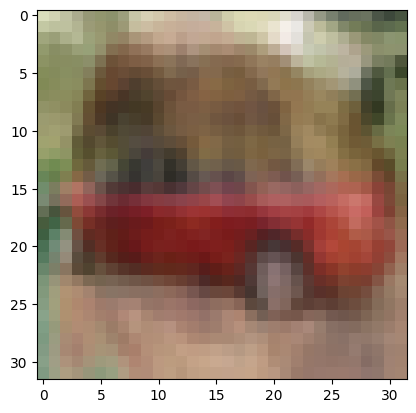

In [73]:
testgen1 = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,1)
x, y = next(datagen)

guesses = vit_predict(x)
guess1 = classes[np.argmax(guesses[0],axis=1)[0]]
guess2 = classes[np.argmax(guesses[0],axis=1)[0]+5]

print("Real - first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])
print("Predicted - first: {}, second = {}".format(guess1,guess2))

As expected, the accuracy is around 1/5 = 0.2

Let us repeat the evaluation ten times, and compute the standard deviation

In [75]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(vit_predict))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
mean accuracy =  0.6318349999999999
standard deviation =  0.0025268607005531746


In [77]:
vit_classifier.save_weights('model_weights.weights.h5')

In [ ]:
vit_classifier.save()

# What to Submit

As usual, you need to submit a single notebook that must be executable on Colab. The notebook should be properly commented and include a complete record of the training process, as well as the calculation of accuracy according to the guidelines provided above.

# Good luck!

